In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

#Import required csv files
genomeTagsFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\genome-tags.csv"
genomeScoresFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\genome-scores.csv"
moviesFilePath = "C:\\Users\\Ben\\OneDrive\\School\\School 2020-21\\Citadel Datathon\\West Coast Datathon Materials\\movie_lense\\movie_lense\\movies.csv"

genomeTags = pd.read_csv(genomeTagsFilePath)
genomeScores = pd.read_csv(genomeScoresFilePath)
movies = pd.read_csv(moviesFilePath)

In [4]:
movies.head()
movies.shape

(58098, 3)

In [5]:
genomeTags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [6]:
genomeScores.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


In [66]:
#Create joined matrix with title, tag, and relevance
joinedDf = genomeScores.set_index('tagId').join(genomeTags.set_index('tagId'))
joinedDf = joinedDf.sort_values('movieId',axis=0).reset_index()

#Select number of movies to analyze
numMoviesToSelect = 1000
joinedDf = joinedDf.loc[joinedDf['movieId'] <= numMoviesToSelect]
movieDf = movies.loc[movies['movieId'] <= numMoviesToSelect, 'title']

#Only include relevant parameters
joinedDf = joinedDf.set_index('movieId').join(movies.set_index('movieId'))
joinedDf = joinedDf[['title','tag','relevance']]

movieDf

0                        Toy Story (1995)
1                          Jumanji (1995)
2                 Grumpier Old Men (1995)
3                Waiting to Exhale (1995)
4      Father of the Bride Part II (1995)
                      ...                
977              Last Man Standing (1996)
978                         Caught (1996)
979                     Set It Off (1996)
980           2 Days in the Valley (1996)
981                        Curdled (1996)
Name: title, Length: 982, dtype: object

In [23]:
#Create joined matrix with title, tag, and relevance
joinedDf = genomeScores.set_index('tagId').join(genomeTags.set_index('tagId'))
joinedDf = genomeScores.loc[genomeScores['movieId'] <= 100]


#joinedDf = joinedDf.drop_duplicates(['title','tag'])
joinedDf


KeyError: &quot;[&#39;tag&#39;] not in index&quot;

In [8]:
joinedDf.head(25)

,title,tag,relevance
movieId,,,
1,Toy Story (1995),007,0.02900
1,Toy Story (1995),private detective,0.01975
1,Toy Story (1995),product placement,0.19975
1,Toy Story (1995),biting,0.05750
1,Toy Story (1995),prohibition,0.01925
1,Toy Story (1995),propaganda,0.08075
1,Toy Story (1995),birds,0.10925
1,Toy Story (1995),prostitution,0.05100
1,Toy Story (1995),biopic,0.06350


In [14]:
test = joinedDf.loc[joinedDf['tag'] == 'biopic']
test = test['relevance'].mean()
test

0.09361039626508769

In [91]:
joined = joinedDf['title'].unique()
joined.sort()
print(joined)

[&quot;&#39;Til There Was You (1997)&quot; &#39;1-900 (06) (1994)&#39;
 &#39;2 Days in the Valley (1996)&#39; &#39;2001: A Space Odyssey (1968)&#39;
 &#39;301, 302 (301/302) (1995)&#39; &#39;39 Steps, The (1935)&#39; &#39;8 Seconds (1994)&#39;
 &#39;A Walk in the Sun (1945)&#39; &#39;Above the Rim (1994)&#39;
 &#39;Ace Ventura: Pet Detective (1994)&#39;
 &#39;Ace Ventura: When Nature Calls (1995)&#39; &#39;Across the Sea of Time (1995)&#39;
 &#39;Addams Family Values (1993)&#39; &#39;Addiction, The (1995)&#39;
 &#39;Adventures of Pinocchio, The (1996)&#39;
 &#39;Adventures of Priscilla, Queen of the Desert, The (1994)&#39;
 &#39;Adventures of Robin Hood, The (1938)&#39; &#39;Affair to Remember, An (1957)&#39;
 &#39;African Queen, The (1951)&#39; &#39;Age of Innocence, The (1993)&#39;
 &#39;Air Up There, The (1994)&#39; &#39;Airheads (1994)&#39; &#39;Aladdin (1992)&#39;
 &#39;Alaska (1996)&#39; &#39;Algiers (1938)&#39; &#39;All About Eve (1950)&#39;
 &#39;All Dogs Go to Heaven 2 (1996)&

In [80]:
#Create pivot table to show relevance across the tags for each movie
pivotedDf = joinedDf.pivot(index='title', columns='tag', values='relevance')
pivotedDf

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.04600,0.05175,0.03975,0.03900,0.05325,0.03925,0.04400,0.06450,0.03375,0.02225,...,0.04450,0.02325,0.01100,0.03000,0.39500,0.22550,0.01925,0.00750,0.11025,0.01625
1-900 (06) (1994),0.03425,0.03925,0.02750,0.02150,0.03350,0.01525,0.01500,0.15300,0.02250,0.01050,...,0.03825,0.02850,0.01075,0.01400,0.13875,0.02875,0.05725,0.00875,0.12875,0.02675
2 Days in the Valley (1996),0.03375,0.03700,0.03325,0.03125,0.05425,0.02550,0.02625,0.14625,0.04150,0.01875,...,0.05900,0.02225,0.01825,0.08750,0.58800,0.20950,0.03050,0.01550,0.09575,0.01700
2001: A Space Odyssey (1968),0.03075,0.01950,0.30275,0.08325,0.06675,0.28725,0.24250,0.24175,0.07950,0.05200,...,0.07525,0.02550,0.01875,0.07675,0.14900,0.13025,0.03300,0.01175,0.06875,0.01725
"301, 302 (301/302) (1995)",0.04475,0.05325,0.02675,0.03425,0.06425,0.05025,0.02125,0.05350,0.04975,0.00900,...,0.16575,0.01800,0.01850,0.02350,0.30275,0.02175,0.03575,0.00925,0.08675,0.01650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wooden Man's Bride, The (Yan shen) (1994)",0.02050,0.02150,0.08775,0.18125,0.09875,0.03400,0.01675,0.16675,0.03450,0.03625,...,0.03850,0.03975,0.02800,0.05075,0.18375,0.03550,0.23000,0.02825,0.12275,0.02775
"World of Apu, The (Apur Sansar) (1959)",0.01550,0.01750,0.06025,0.12500,0.04375,0.08375,0.03925,0.09500,0.00975,0.06900,...,0.03250,0.03775,0.01525,0.30825,0.23175,0.05675,0.08500,0.01250,0.06850,0.01800
Wyatt Earp (1994),0.04625,0.04300,0.05025,0.05125,0.05675,0.06325,0.03075,0.11750,0.08350,0.13525,...,0.05550,0.03000,0.00975,0.03850,0.19500,0.04325,0.02375,0.00925,0.09575,0.01750


In [46]:
def SwitchPivotToZScore(pivotedDf):
    meanRelevance = pd.DataFrame()
    meanRelevance['mean'] = pivotedDf.mean()
    meanRelevance['std'] = pivotedDf.std()

    for column in pivotedDf:
        pivotedDf[column] = pivotedDf[column].apply(lambda val:(val-meanRelevance.loc[column,'mean'])/meanRelevance.loc[column,'std'])

    print(meanRelevance)
    return pivotedDf

test = SwitchPivotToZScore(pivotedDf)
test

                      mean       std
007           2.209430e-17  0.050827
007 (series)  8.338913e-18  0.064246
18th century  1.525792e-16  0.140945
1920s        -1.155207e-16  0.078029
1930s         3.664532e-17  0.171793
...                    ...       ...
writing       1.553027e-17  0.071613
wuxia         8.024865e-17  0.070158
wwii         -5.579422e-17  0.099995
zombie       -3.612509e-17  0.057667
zombies       1.577126e-17  0.045270

[1128 rows x 2 columns]


tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.132039,0.149653,-0.350145,-0.503820,-0.465279,-0.456567,-0.161755,-0.783283,-0.506988,-0.392009,...,-0.431055,-0.290068,-0.296051,-0.424129,1.402844,2.061115,-0.264054,-0.260895,0.036498,-0.138863
1-900 (06) (1994),-0.099138,-0.044911,-0.437059,-0.728096,-0.580243,-0.643487,-0.563590,0.304635,-0.711196,-0.497204,...,-0.479989,-0.210632,-0.298254,-0.656146,-0.863403,-0.686288,0.277577,-0.248394,0.357308,0.093076
2 Days in the Valley (1996),-0.108975,-0.079932,-0.396262,-0.603143,-0.459458,-0.563657,-0.407706,0.221658,-0.366312,-0.423343,...,-0.317530,-0.305199,-0.232162,0.409684,3.109715,1.837692,-0.103703,-0.180891,-0.214947,-0.122296
2001: A Space Odyssey (1968),-0.167999,-0.352321,1.515833,0.063277,-0.386696,1.474935,2.588740,1.395626,0.323454,-0.125663,...,-0.190304,-0.256024,-0.227755,0.253797,-0.772753,0.731051,-0.068069,-0.218393,-0.683156,-0.116773
"301, 302 (301/302) (1995)",0.107446,0.173001,-0.442380,-0.564695,-0.401249,-0.370896,-0.476988,-0.918505,-0.216560,-0.510633,...,0.518250,-0.369504,-0.229958,-0.518386,0.586995,-0.784035,-0.028872,-0.243394,-0.371016,-0.133340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wooden Man's Bride, The (Yan shen) (1994)",-0.369663,-0.321191,-0.009586,1.319221,-0.200426,-0.497456,-0.539342,0.473661,-0.493375,-0.266669,...,-0.478031,-0.040412,-0.146241,-0.123231,-0.465428,-0.592031,2.739862,-0.053385,0.253262,0.115166
"World of Apu, The (Apur Sansar) (1959)",-0.468036,-0.383451,-0.204698,0.598335,-0.520578,-0.109987,-0.227573,-0.408351,-0.942631,0.026535,...,-0.525007,-0.070674,-0.258599,3.610800,-0.040921,-0.295298,0.673111,-0.210892,-0.687491,-0.100206
Wyatt Earp (1994),0.136957,0.013459,-0.275648,-0.346827,-0.444906,-0.269648,-0.345352,-0.131762,0.396062,0.619659,...,-0.344933,-0.187936,-0.307066,-0.300870,-0.365934,-0.483811,-0.199914,-0.243394,-0.214947,-0.111251


In [52]:
def findTopGenomeTags(pivoted, numTagsToReturn = 15):
    meanRelevance = pivoted.mean()
    meanRelevance = meanRelevance.sort_values(ascending=False)

    meanRelevanceReduced = meanRelevance.iloc[:numTagsToReturn]
    print(meanRelevanceReduced)
    
    avgRelevanceScore = meanRelevanceReduced.mean().round(5)
    print("Average Relevance Score: ", avgRelevanceScore)
    topNTags = meanRelevanceReduced.index.values.tolist()
    #print(topNTags)

    pivoted = pivoted[topNTags]
    #print(pivoted.head())  
    
    return pivoted

    
#findTopGenomeTags(pivotedDf.iloc[:50,:50])

In [74]:
pivotedDf.sort_index()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.132039,0.149653,-0.350145,-0.503820,-0.465279,-0.456567,-0.161755,-0.783283,-0.506988,-0.392009,...,-0.431055,-0.290068,-0.296051,-0.424129,1.402844,2.061115,-0.264054,-0.260895,0.036498,-0.138863
1-900 (06) (1994),-0.099138,-0.044911,-0.437059,-0.728096,-0.580243,-0.643487,-0.563590,0.304635,-0.711196,-0.497204,...,-0.479989,-0.210632,-0.298254,-0.656146,-0.863403,-0.686288,0.277577,-0.248394,0.357308,0.093076
2 Days in the Valley (1996),-0.108975,-0.079932,-0.396262,-0.603143,-0.459458,-0.563657,-0.407706,0.221658,-0.366312,-0.423343,...,-0.317530,-0.305199,-0.232162,0.409684,3.109715,1.837692,-0.103703,-0.180891,-0.214947,-0.122296
2001: A Space Odyssey (1968),-0.167999,-0.352321,1.515833,0.063277,-0.386696,1.474935,2.588740,1.395626,0.323454,-0.125663,...,-0.190304,-0.256024,-0.227755,0.253797,-0.772753,0.731051,-0.068069,-0.218393,-0.683156,-0.116773
"301, 302 (301/302) (1995)",0.107446,0.173001,-0.442380,-0.564695,-0.401249,-0.370896,-0.476988,-0.918505,-0.216560,-0.510633,...,0.518250,-0.369504,-0.229958,-0.518386,0.586995,-0.784035,-0.028872,-0.243394,-0.371016,-0.133340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wooden Man's Bride, The (Yan shen) (1994)",-0.369663,-0.321191,-0.009586,1.319221,-0.200426,-0.497456,-0.539342,0.473661,-0.493375,-0.266669,...,-0.478031,-0.040412,-0.146241,-0.123231,-0.465428,-0.592031,2.739862,-0.053385,0.253262,0.115166
"World of Apu, The (Apur Sansar) (1959)",-0.468036,-0.383451,-0.204698,0.598335,-0.520578,-0.109987,-0.227573,-0.408351,-0.942631,0.026535,...,-0.525007,-0.070674,-0.258599,3.610800,-0.040921,-0.295298,0.673111,-0.210892,-0.687491,-0.100206
Wyatt Earp (1994),0.136957,0.013459,-0.275648,-0.346827,-0.444906,-0.269648,-0.345352,-0.131762,0.396062,0.619659,...,-0.344933,-0.187936,-0.307066,-0.300870,-0.365934,-0.483811,-0.199914,-0.243394,-0.214947,-0.111251


In [81]:
pivotedDf.index.values


   &#39;From the Journals of Jean Seberg (1995)&#39;, &#39;Fugitive, The (1993)&#39;,
       &#39;Funny Face (1957)&#39;, &#39;Gaslight (1944)&#39;,
       &#39;Gate of Heavenly Peace, The (1995)&#39;, &#39;Gay Divorcee, The (1934)&#39;,
       &#39;Georgia (1995)&#39;, &#39;Germinal (1993)&#39;,
       &#39;Geronimo: An American Legend (1993)&#39;, &#39;Get Shorty (1995)&#39;,
       &#39;Getaway, The (1994)&#39;, &#39;Getting Away With Murder (1996)&#39;,
       &#39;Getting Even with Dad (1994)&#39;, &#39;Ghost (1990)&#39;,
       &#39;Ghost and Mrs. Muir, The (1947)&#39;,
       &#39;Ghost in the Shell (Kôkaku kidôtai) (1995)&#39;, &#39;Giant (1956)&#39;,
       &#39;Gigi (1958)&#39;, &#39;Girl 6 (1996)&#39;, &#39;Girls Town (1996)&#39;,
       &#39;Go Fish (1994)&#39;, &#39;Godfather, The (1972)&#39;,
       &#39;Gold Diggers: The Secret of Bear Mountain (1995)&#39;,
       &#39;Golden Earrings (1947)&#39;, &#39;GoldenEye (1995)&#39;,
       &quot;Gone Fishin&#39; (1997)&quot;, &#

In [94]:
tagList = genomeTags['tag'].tolist() #list of all genome tags


#Train Kmeans algorithm
X = pivotedDf[tagList].values
kmeans = KMeans(n_clusters=80)
predictions = kmeans.fit_predict(X)

predictions



array([14, 26, 37, 25,  3, 41, 46, 20,  1, 15, 15, 11, 54, 32, 60, 79, 40,
       14, 61, 12, 16, 54,  9, 48, 52,  4, 22, 57, 29, 62, 48, 18, 14, 40,
       48, 21, 18, 12, 70, 42, 16, 52, 61, 63, 22, 60, 24, 36,  8, 20, 18,
       22, 48, 18, 26, 78,  8, 45, 16, 23, 22, 31, 65, 11, 62, 27, 38, 59,
       59, 18, 62,  9, 29, 14, 52, 45,  0, 26, 54,  8, 26, 21, 20, 48, 48,
        7, 26, 15, 26, 15, 79, 56, 60, 15, 71, 17, 56, 49,  8,  1, 20, 18,
       72, 48, 16, 62,  2, 51, 26, 79, 57, 20, 54, 19, 57, 47, 14, 61,  8,
       37, 26, 23, 20, 57,  8,  7,  0, 48, 56, 13, 15, 15, 70, 30, 72, 20,
        3, 37, 23, 48, 56, 12, 61, 37, 48, 72,  4, 26, 20, 53, 16, 32,  8,
       41, 16, 36, 23, 70,  4, 45, 16, 73, 54, 68, 62, 68,  8, 27, 70, 21,
       47, 23, 37,  3, 23, 17, 21, 54, 57, 65, 26, 54, 17, 20,  7, 20, 52,
       55, 16, 70, 55, 32, 57, 18, 77, 72, 23, 26, 38, 57, 18, 46, 49,  3,
       23, 63, 26, 26, 46, 14, 23,  5, 62, 36, 76, 21,  3, 18, 18, 23, 56,
       28,  3, 37, 26,  2

In [97]:
movieTitlesList = movies['title'].tolist()

movieListDf = pd.DataFrame()
movieListDf['title'] = joined

clustered = pd.concat([movieListDf, pd.DataFrame({'group':predictions})], axis=1)
clustered

,title,group
0,'Til There Was You (1997),14
1,1-900 (06) (1994),26
2,2 Days in the Valley (1996),37
3,2001: A Space Odyssey (1968),25
4,"301, 302 (301/302) (1995)",3
...,...,...
902,"Wooden Man's Bride, The (Yan shen) (1994)",23
903,"World of Apu, The (Apur Sansar) (1959)",44
904,Wyatt Earp (1994),21
905,"Yes, Madam (a.k.a. Police Assassins) (a.k.a. I...",49


tag
comedy             0.903692
goofy              0.894827
hilarious          0.832500
stupidity          0.824058
very funny         0.802000
funny              0.796923
dumb               0.785750
funniest movies    0.736000
original           0.733577
dumb but funny     0.727923
stupid             0.725365
silly fun          0.715750
idiotic            0.714500
funny as hell      0.701731
silly              0.661327
dtype: float64
Average Relevance Score:  0.77039


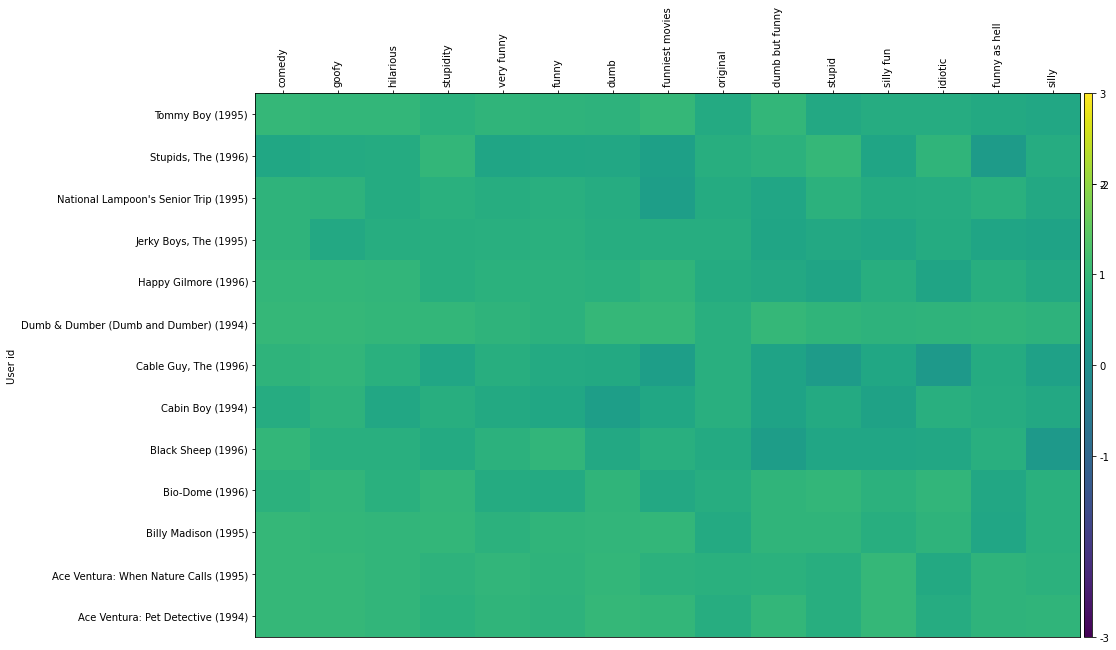

In [107]:
#Pick a cluster number to analyze
clusterNum = 15
cluster = clustered.loc[clustered['group'] == clusterNum]['title'].tolist()
#print(cluster)

#Draw a heatmap for the selected cluster
reduced_pivot = pivotedDf.loc[pivotedDf.index.isin(cluster)]
reduced_pivot = findTopGenomeTags(reduced_pivot) #only show the top associated tags
draw_movies_heatmap(reduced_pivot)

In [106]:
# Define the plotting heatmap function
def draw_movies_heatmap(pivoted, axis_labels=True):
    
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(pivoted,  interpolation='nearest', vmin=-3, vmax=3, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(pivoted.shape[0]) , minor=False)
        ax.set_xticks(np.arange(pivoted.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = pivoted.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(pivoted.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[3, 2, 1, 0, -1, 2, -3], cax=cax)
    cbar.ax.set_yticklabels(['3','2','1','0','-1','-2','-3'])
plt.show()
# Print the heatmap
#draw_movies_heatmap(pivoted.iloc[:10,:30])

tag
original           0.763110
mentor             0.512120
storytelling       0.502090
great ending       0.492495
catastrophe        0.486815
dialogue           0.468480
good               0.451775
runaway            0.433475
good soundtrack    0.432720
story              0.427310
vengeance          0.422415
great              0.417260
chase              0.417105
brutality          0.409880
weird              0.399875
dtype: float64
[&#39;original&#39;, &#39;mentor&#39;, &#39;storytelling&#39;, &#39;great ending&#39;, &#39;catastrophe&#39;, &#39;dialogue&#39;, &#39;good&#39;, &#39;runaway&#39;, &#39;good soundtrack&#39;, &#39;story&#39;, &#39;vengeance&#39;, &#39;great&#39;, &#39;chase&#39;, &#39;brutality&#39;, &#39;weird&#39;]


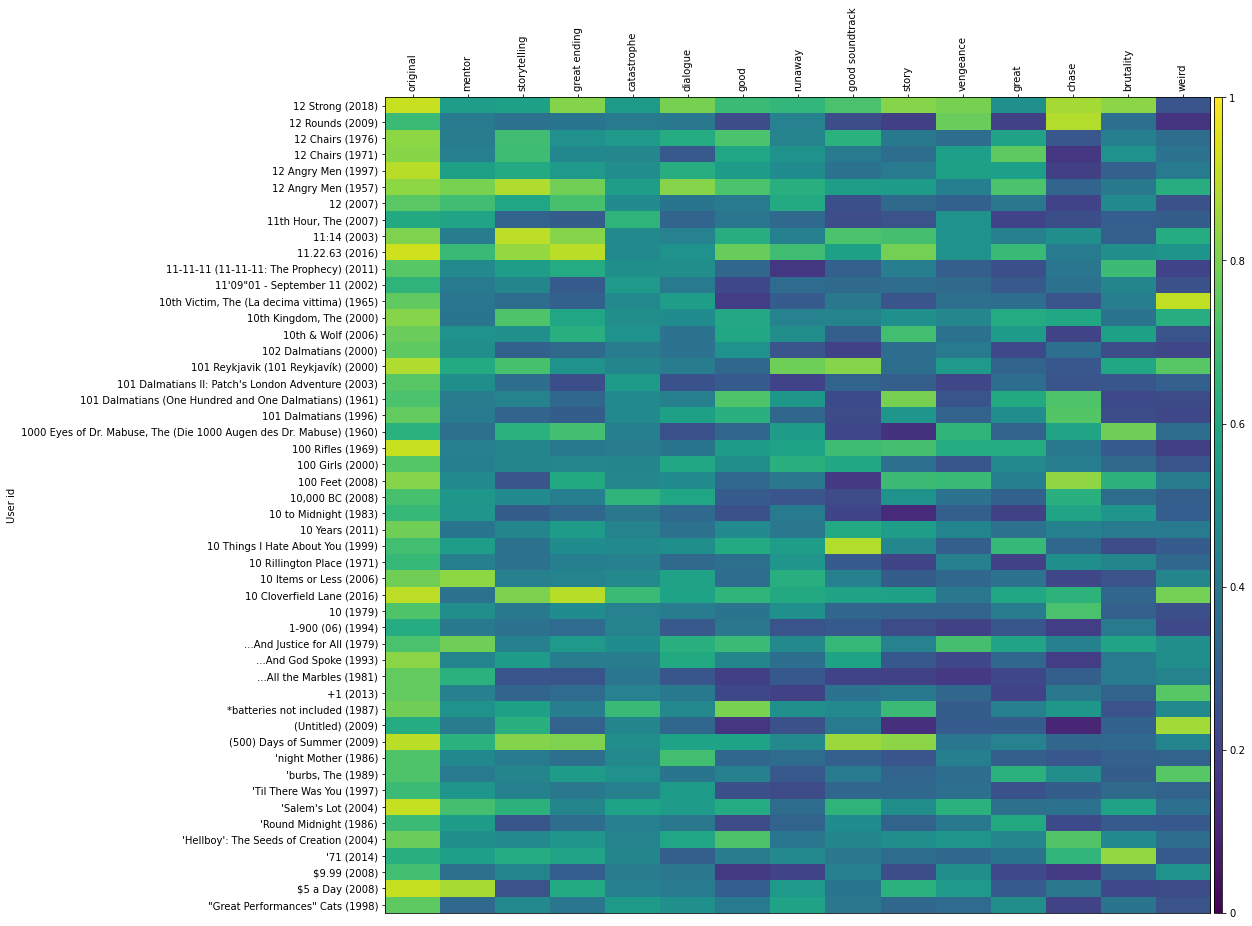

In [169]:
#Random testing

reduced_pivot = findTopGenomeTags(pivoted.iloc[:50])
draw_movies_heatmap(reduced_pivot)